In [114]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [115]:
import numpy as np
import pandas as pd

In [116]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [117]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, text

In [118]:
engine = create_engine("sqlite:///./hawaii.sqlite")

In [119]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [120]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [121]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [122]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [123]:
# Get the columns of measurement table
Measurement.__table__.columns.values()

[Column('id', INTEGER(), table=<measurement>, primary_key=True, nullable=False),
 Column('station', TEXT(), table=<measurement>),
 Column('date', TEXT(), table=<measurement>),
 Column('prcp', FLOAT(), table=<measurement>),
 Column('tobs', FLOAT(), table=<measurement>)]

In [124]:
# Get the columns of Station table
Station.__table__.columns.values()

[Column('id', INTEGER(), table=<station>, primary_key=True, nullable=False),
 Column('station', TEXT(), table=<station>),
 Column('name', TEXT(), table=<station>),
 Column('latitude', FLOAT(), table=<station>),
 Column('longitude', FLOAT(), table=<station>),
 Column('elevation', FLOAT(), table=<station>)]

# Exploratory Climate Analysis

In [125]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results


# date 1 year ago from today
# year_ago = dt.date.today() - dt.timedelta(days=365)
   
####################################################################################################    
# Get the max date and take that as reference  to get data as last 12 months 
max_date= session.query(Measurement.date).order_by(Measurement.date.desc()).first() [0]
print(max_date)
query_date=dt.datetime.strptime(max_date,'%Y-%m-%d')- dt.timedelta(days=365)
print(query_date)
# Perform a query to retrieve the data and precipitation scores

# results = session.query(func.avg(Measurement.prcp), Measurement.date).\
#           filter(Measurement.date >='2016-08-23').group_by(Measurement.date).\
#                             order_by(Measurement.date).all()

######################################################################################


results = session.query(Measurement.prcp, Measurement.date).\
          filter(Measurement.date >=query_date).all() 
 
   



2017-08-23
2016-08-23 00:00:00


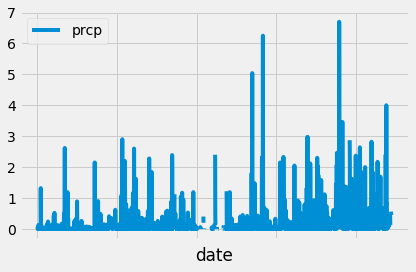

In [126]:
# Save the query results as a Pandas DataFrame and set the index to the date column

df = pd.DataFrame(results, columns=['prcp', 'date'])
df.set_index('date', inplace=True)
# Sort the dataframe by date
df.sort_values(by=['date'])
df.head()



df.plot()
plt.xlabel("date")
plt.tight_layout()
plt.show()


In [127]:
# Use Pandas to calcualte the summary statistics for the precipitation data
#
df_summary=df.describe()


df_summary

,prcp
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [128]:
# How many stations are available in this dataset?
session.query(Measurement.station).group_by(Measurement.station).count()

9

In [129]:
# What are the most active stations?
session.query(func.count(Measurement.station), Measurement.station).\
                 group_by(Measurement.station).\
                  order_by(func.count(Measurement.station).desc()).all()


# List the stations and the counts in descending order.


[(2772, 'USC00519281'),
 (2724, 'USC00519397'),
 (2709, 'USC00513117'),
 (2669, 'USC00519523'),
 (2612, 'USC00516128'),
 (2202, 'USC00514830'),
 (1979, 'USC00511918'),
 (1372, 'USC00517948'),
 (511, 'USC00518838')]

In [130]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?

session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)).\
                filter(Measurement.station=='USC00519281').all()

[(54.0, 85.0, 71.66378066378067)]

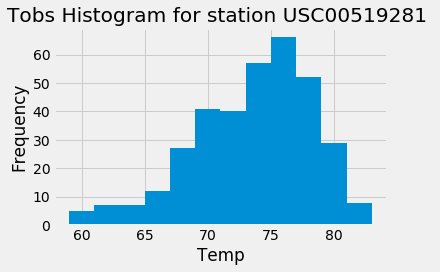

In [138]:
#  Filter by the station with the highest number of observations.
# Plot the results as a histogram with bins=12.

results_temp = session.query(Measurement.tobs, Measurement.date).\
              filter(Measurement.date >=query_date).\
              filter(Measurement.station=='USC00519281').group_by(Measurement.date).\
                all()

df_temp = pd.DataFrame(results_temp, columns=['temp', 'date'])

df_temp.hist(column='temp',bins=12)
plt.xlabel("Temp")
plt.ylabel("Frequency")
plt.title("Tobs Histogram for station USC00519281 ")
plt.tight_layout()





In [132]:
# Write a function called `calc_temps` that will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [139]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
results_1=(calc_temps(query_date, max_date))

df_temp = pd.DataFrame(results_1, columns=['min_tmp', 'avg_tmp','max_tmp'])
print(df_temp)


   min_tmp    avg_tmp  max_tmp
0     58.0  74.578947     87.0


<BarContainer object of 1 artists>

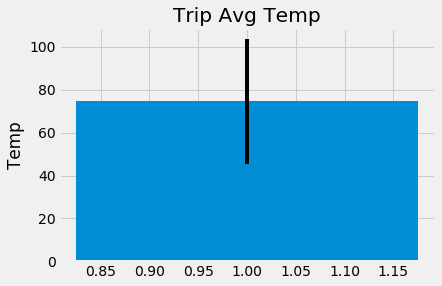

In [140]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)


N = 1
Means = df_temp["avg_tmp"][0]
Std = df_temp["max_tmp"][0]-df_temp["min_tmp"][0]
ind = np.arange(N)    # the x locations for the groups
width = 0.35       # the width of the bars: can also be len(x) sequence

# plt.figure()
plt.ylabel('Temp')
plt.title('Trip Avg Temp')
plt.bar(1, Means, width, yerr=Std)




In [135]:
# Calculate the rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation



## Optional Challenge Assignment

In [20]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [21]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


[(62.0, 69.15384615384616, 77.0),
 (60.0, 69.39622641509433, 77.0),
 (62.0, 68.9090909090909, 77.0),
 (58.0, 70.0, 76.0),
 (56.0, 67.96428571428571, 76.0),
 (61.0, 68.96491228070175, 76.0),
 (57.0, 68.54385964912281, 76.0)]

In [22]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


,tmin,tavg,tmax
date,,,
2018-01-01,62.0,69.153846,77.0
2018-01-02,60.0,69.396226,77.0
2018-01-03,62.0,68.909091,77.0
2018-01-04,58.0,70.000000,76.0
2018-01-05,56.0,67.964286,76.0


<IPython.core.display.Javascript object>


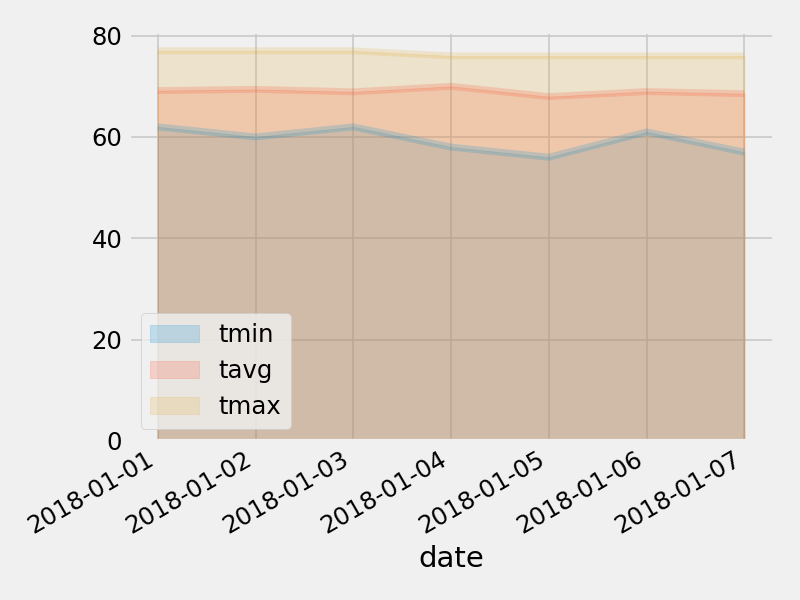

In [23]:
# Plot the daily normals as an area plot with `stacked=False`
